In [ ]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import os
import dlib
import cv2
import time
import math
import datetime
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import scipy.io
import bz2
from random import randint

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:

if not os.path.exists(os.path.abspath('.') + 'mmod_human_face_detector.dat.bz2'):
    annotation_zip = tf.keras.utils.get_file('mmod_human_face_detector.dat.bz2',
                            cache_subdir=os.path.abspath('.'),
                            origin = "http://dlib.net/files/mmod_human_face_detector.dat.bz2")
# Using pythons bz2 package to read the bz2 file in binary format and write it into a .dat file
with bz2.open("mmod_human_face_detector.dat.bz2", "rb") as f:
    content = f.read()

    with open("mmod_human_face_detector.dat", "wb") as weights_file:
        weights_file.write(content)

os.remove(annotation_zip)

694709/694709 [==============================] - 1s 1us/step


In [ ]:
dataset_url = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'
annotation_folder = "wiki_crop"
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('wiki.tar',
                                            cache_subdir=os.path.abspath('.'),
                                            origin = dataset_url,
                                            extract = True)
    os.remove(annotation_zip)
data_key = 'wiki'
mat_file = 'wiki.mat'

811315200/811315200 [==============================] - 11s 0us/step


In [ ]:
dataset_url = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar'
annotation_folder = "imdb_crop"
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('imdb.tar',
                                            cache_subdir=os.path.abspath('.'),
                                            origin = dataset_url,
                                            extract = True)
    os.remove(annotation_zip)
data_key = 'imdb'
mat_file = 'imdb.mat'

7012157440/7012157440 [==============================] - 140s 0us/step


In [ ]:
!python mat.py

In [ ]:
!python age.py

In [3]:
from keras import backend as K


def age_mae(y_true, y_pred):
    true_age = K.sum(y_true * K.arange(0, 102, dtype="float32"), axis=-1)
    pred_age = K.sum(y_pred * K.arange(0, 102, dtype="float32"), axis=-1)
    mae = K.mean(K.abs(true_age - pred_age))
    return mae


In [4]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Setting up the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('content/dataset/age/train', target_size=(128, 128), batch_size=64, class_mode='categorical')
test_generator = test_datagen.flow_from_directory('content/dataset/age/test', target_size=(128, 128), batch_size=64, class_mode='categorical')

# Building the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling="avg")
x = Dropout(0.5)(base_model.output)

prediction = Dense(units=102, kernel_initializer="he_normal", use_bias=False, activation="softmax",
                       name="pred_age")(x)

model = Model(inputs=base_model.input, outputs=prediction)
# # Freezing the base model layers
# for layer in base_model.layers:
#     layer.trainable = False


Found 179660 images belonging to 102 classes.
Found 44916 images belonging to 102 classes.
94765736/94765736 [==============================] - 1s 0us/step


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint filepath and set the save_best_only parameter to True
checkpoint_filepath = 'best_age_model.h5'
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath, 
    save_best_only=True,
    monitor='val_age_mae', # Choose the metric to monitor for saving the best model
    mode='min', # Set the mode to 'min' if the metric should be minimized, 'max' if it should be maximized
    verbose=1
)


# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=[age_mae])

# Training the model with the checkpoint callback
history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[checkpoint_callback])

# # Saving the model
# model.save('age_model_102.h5')

Epoch 1/20
2808/2808 [==============================] - ETA: 0s - loss: 3.7617 - age_mae: 9.1860
Epoch 1: val_age_mae improved from inf to 8.89575, saving model to best_age_model.h5
2808/2808 [==============================] - 748s 250ms/step - loss: 3.7617 - age_mae: 9.1860 - val_loss: 3.8005 - val_age_mae: 8.8957
Epoch 2/20
2808/2808 [==============================] - ETA: 0s - loss: 3.6042 - age_mae: 8.1201
Epoch 2: val_age_mae improved from 8.89575 to 8.60227, saving model to best_age_model.h5
2808/2808 [==============================] - 681s 243ms/step - loss: 3.6042 - age_mae: 8.1201 - val_loss: 3.7063 - val_age_mae: 8.6023
Epoch 3/20
2808/2808 [==============================] - ETA: 0s - loss: 3.5375 - age_mae: 7.6927
Epoch 3: val_age_mae did not improve from 8.60227
2808/2808 [==============================] - 682s 243ms/step - loss: 3.5375 - age_mae: 7.6927 - val_loss: 3.7494 - val_age_mae: 8.9843
Epoch 4/20
2808/2808 [==============================] - ETA: 0s - loss: 3.4791 -

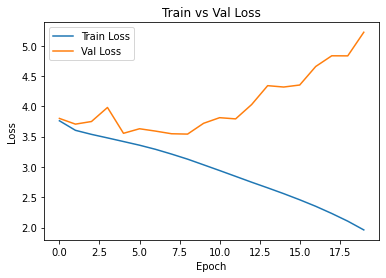

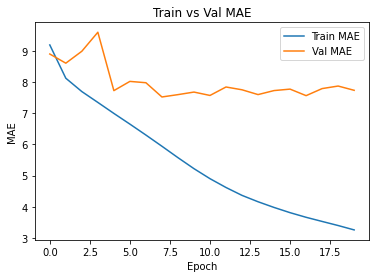

In [6]:
import matplotlib.pyplot as plt

# Plotting the train and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the train and validation metrics
plt.plot(history.history['age_mae'], label='Train MAE')
plt.plot(history.history['val_age_mae'], label='Val MAE')
plt.title('Train vs Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()
